# Brownian Motion Encoder

Create simulation

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
from pygsig.graph import StaticGraphTemporalSignal

class Simulation():
    def __init__( self,
                 num_nodes,
                 num_blocks, 
                 p_across_blocks,
                 p_within_blocks,
                 mu_gain,
                 beta_gain,
                 sigma_gain,
                 omega_noise,
                 time_horizon,
                 task='classification',
                 dt = 1e-3):
        
        self.num_nodes = num_nodes
        self.num_blocks = num_blocks
        self.p_across_blocks = p_across_blocks
        self.p_within_blocks = p_within_blocks
        self.mu_gain = mu_gain
        self.beta_gain = beta_gain
        self.sigma_gain = sigma_gain
        self.omega_noise = omega_noise
        self.time_horizon = time_horizon
        self.dt = dt
        self.num_time_steps = int(time_horizon / dt)
        self.task = task
        self.tt = np.arange(0, self.time_horizon, self.dt)

    def run(self,graph_seed,omega_seed,param_seed):

        # synchronization
        def kuramoto(graph, theta, omega, dt):
            dtheta = omega * dt  # Initialize with intrinsic frequencies
            for u, v, data in graph.edges(data=True):
                coupling = data['weight']
                dtheta[u] += dt * coupling * np.sin(theta[v] - theta[u])
                dtheta[v] += dt * coupling * np.sin(theta[u] - theta[v])
            return theta + dtheta

        # drift of the SDE
        def periodic_drift(beta, theta, omega, mu_0, t):
            return mu_0 + beta*np.sin(omega*t + theta)

        # Create a graph
        block_sizes = [self.num_nodes // self.num_blocks] * self.num_blocks
        block_probs = np.zeros((self.num_blocks, self.num_blocks))

        for i in range(self.num_blocks):
            for j in range(self.num_blocks):
                if i == j:
                    block_probs[i, j] = self.p_within_blocks
                else:
                    block_probs[i, j] = self.p_across_blocks
        
        graph = nx.stochastic_block_model(block_sizes, block_probs, seed=graph_seed)

        for edge in graph.edges:
            if graph.nodes[edge[0]]['block'] == graph.nodes[edge[1]]['block']:
                graph[edge[0]][edge[1]]['weight'] = 1/(np.sqrt(graph.degree[edge[0]]*graph.degree[edge[1]]))
            else:
                graph[edge[0]][edge[1]]['weight'] = 1/(np.sqrt(graph.degree[edge[0]]*graph.degree[edge[1]]))
        
        # Assign omega to each node
        np.random.seed(omega_seed)
        omega_range = np.linspace(0,1, self.num_blocks+1)[1:]
        for node in graph.nodes:
            graph.nodes[node]['omega'] = max(omega_range[graph.nodes[node]['block']] + self.omega_noise * np.random.randn(),1e-3)
        
        # Othe oscilator perameters
        np.random.seed(param_seed)
        omega = np.array([graph.nodes[node]['omega'] for node in graph.nodes])
        block = np.array([graph.nodes[node]['block'] for node in graph.nodes])
        beta =  self.beta_gain * np.random.rand(self.num_nodes) # amplitude (uniform nodes)
        theta = 2 * np.pi * np.random.rand(self.num_nodes)  # initial phase (random across nodes)
        mu_0 = self.mu_gain * np.random.rand(self.num_nodes)

        # initial values
        X = np.random.rand(self.num_nodes) # signal

        # Simulate
        theta_traj = np.zeros((self.num_nodes,self.num_time_steps))
        mu_traj = np.zeros((self.num_nodes,self.num_time_steps))
        X_traj = np.zeros((self.num_nodes,self.num_time_steps))

        # Time sequence
        tt = np.arange(0, self.time_horizon, self.dt)
        for step,t in enumerate(tt):
            theta_traj[:, step] = theta
            if step == 0:
                mu_traj[:,step] = mu_0
            else:
                mu_traj[:,step] = mu
            X_traj[:,step] = X
            theta = kuramoto(graph, theta, omega,self.dt)
            mu = periodic_drift(beta, theta,omega, mu_0, t)
            X = X + self.dt * mu + np.sqrt(self.dt) * self.sigma_gain*np.random.randn(self.num_nodes)
        
        self.X = X_traj
        self.theta = theta_traj
        self.mu = mu_traj
        self.block = block
        self.omega = omega
        self.mu_0 = mu_0
        self.beta = beta
        self.graph = graph
    
    def get_sequence(self):
        from sklearn.preprocessing import OneHotEncoder
        one_hot = OneHotEncoder()

        if self.task == 'classification':
            y = one_hot.fit_transform(self.block.reshape(-1,1)).toarray()
        if self.task == 'regression':
            y = self.omega.reshape(-1,1)

        snapshot_count = self.X.shape[1]
        df_edge = nx.to_pandas_edgelist(self.graph.to_directed())
        edge_index = torch.tensor(df_edge[['source','target']].values.T,dtype=torch.long)
        edge_weight = torch.tensor(df_edge['weight'].values,dtype=torch.float)
        snapshot_count = self.X.shape[1]
        features = [ torch.tensor(self.X[:,t],dtype=torch.float).unsqueeze(-1) for t in range(snapshot_count)]
        targets = [ y for _ in range(snapshot_count)]
        # Sequential Data
        return StaticGraphTemporalSignal(edge_index=edge_index,edge_weight=edge_weight,features=features,targets=targets)


In [6]:
from pygsig.datasets.brownian import Simulation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

simulation =   Simulation(num_nodes= 12,
                num_blocks=3,
                p_across_blocks=0.25,
                p_within_blocks=0.75,
                mu_gain= 1.0,
                beta_gain=5.0,
                sigma_gain=1.0,
                omega_noise=0.0,
                time_horizon=20,
                dt=1e-1)

simulation.run(graph_seed=32,omega_seed=29,param_seed=29)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.cm as cm

# Get block information for each node
blocks = nx.get_node_attributes(simulation.graph, 'block')

# Define the color map for different blocks (Viridis colormap)
unique_blocks = list(set(blocks.values()))
colors = cm.get_cmap('viridis', len(unique_blocks))(np.linspace(0, 1, len(unique_blocks)))
block_color_map = {block: colors[i] for i, block in enumerate(unique_blocks)}

# Set positions for the nodes in the graph
pos = nx.circular_layout(simulation.graph)

# Create subplots for each node
fig, axs = plt.subplots(len(simulation.graph.nodes), 2, figsize=(10, 2 * len(simulation.graph.nodes)))

# Default node size and size for the featured node
node_size_default = 15
node_size_featured = 30

for i, node in enumerate(simulation.graph.nodes):
    # Graph subplot (left)
    ax1 = axs[i, 0]
    
    # Draw all nodes with the standard size, but make the current node twice as large
    nx.draw(simulation.graph, pos=pos, 
            node_color=[block_color_map[blocks[n]] for n in simulation.graph.nodes],  # Color all nodes using Viridis colormap
            node_size=[node_size_featured if n == node else node_size_default for n in simulation.graph.nodes],  # Make the featured node bigger
            font_size=10, 
            font_color='white', 
            ax=ax1)
    
    # Highlight the featured node with a larger size
    nx.draw_networkx_nodes(simulation.graph, pos, nodelist=[node], 
                           node_color=[block_color_map[blocks[node]]], 
                           node_size=node_size_featured, ax=ax1)

    # Remove the axis for the graph plot and set aspect ratio to 1:1
    ax1.set_aspect('equal')
    ax1.set_axis_off()

    # Time series subplot (right)
    sns.lineplot(x=np.linspace(0, 10, simulation.X.shape[1]), 
                 y=simulation.X[node, :], 
                 color=block_color_map[blocks[node]], 
                 ax=axs[i, 1])

    # Customize labels and remove unnecessary spines
    axs[i, 1].set_xlabel('Time')
    sns.despine(ax=axs[i, 1])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# Plot all time series on the same graph
plt.figure(figsize=(12, 6))
for node in simulation.graph.nodes:
    sns.lineplot(x=np.linspace(0, 10, simulation.X.shape[1]), 
                 y=simulation.X[node, :], 
                 color=block_color_map[blocks[node]], 
                 label=f'{node}')

plt.xlabel('Time')
plt.legend()
plt.show()

# Lead lag embedding
X_reshaped = simulation.X.reshape(-1, simulation.X.shape[-1],1)
X_leadlag = np.zeros((simulation.X.shape[0], 2*simulation.X.shape[1]-1, 2))
X_leadlag[:,0::2,:] = np.concatenate((X_reshaped,X_reshaped),axis=-1)
X_leadlag[:,1::2,:] = np.concatenate((X_reshaped[:,1:,:],X_reshaped[:,:-1,:]),axis=-1)


plt.figure(figsize=(12, 6))
t_min = 0
t_max = 200
for node in simulation.graph.nodes:
    plt.plot(X_leadlag[node, t_min:t_max, 0],X_leadlag[node, t_min:t_max, 1], color= block_color_map[blocks[node]],label=f'{node}')

Make dataset consisting of multiple SDE trajectories

In [2]:
from tqdm import tqdm

simulation =   Simulation(  num_nodes= 300,
                            num_blocks=3,
                            p_across_blocks=0.01,
                            p_within_blocks=0.1,
                            mu_gain= 1,
                            beta_gain=4,
                            sigma_gain=1.0,
                            omega_noise=0.1,
                            time_horizon=10,
                            dt=1e-3,
                            task = 'regression',
                        )

seq_dataset = []
num_runs = 10

seed = 29
with tqdm(total=num_runs) as pbar:
    for run in range(num_runs):
        simulation.run(graph_seed=seed+run,omega_seed=seed+run,param_seed=seed+run)
        seq_dataset.append(simulation.get_sequence())
        pbar.update(1)

100%|██████████| 10/10 [04:08<00:00, 24.89s/it]


## Signature

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from signatory import signature_channels
from pygsig.signature import SignatureFeatures


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNRegression, MLPRegression
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = seq_dataset[0].num_nodes
dim = seq_dataset[0].num_node_features
out_channels = 1
num_splits = 5 # split the nodes
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 400

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

all_models = []
all_model_parameters = []
all_model_depths = []
all_model_layers = []
all_models_mse = []
all_models_mae = []
all_models_rmse = []

# create models 
min_depth = 4
max_depth = 4
min_layers = 3
max_layers = 3


for depth in range(min_depth,max_depth+1):
    print(f'Signature depth: {depth}')
    
    # encode sequences with signature w/ lead-lag embedding
    dataset = []
    for seq in tqdm(seq_dataset):
        signature_transform = SignatureFeatures(sig_depth=depth, normalize=True, log_signature=False,lead_lag=True)
        dataset.append(signature_transform(seq))

    for num_layers in range(min_layers,max_layers+1):
        in_channels = signature_channels(2*dim,depth)
        model = GCNRegression(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Name: {model._get_name()}')
        print(f"Number of parameters: {num_params}")
        print(f"Number of layers: {num_layers+1}")
        print(f"Signature depth: {depth}")
        print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
        all_model_parameters.append(num_params)
        all_model_layers.append(num_layers+1)
        all_model_depths.append(depth)
        
        criterion = nn.MSELoss() # loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 
        train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
        eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
        mse = np.zeros([num_splits, num_runs, num_trials])
        mae = np.zeros([num_splits, num_runs, num_trials])
        rmse = np.zeros([num_splits, num_runs, num_trials])

        with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
            splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
            for split in range(num_splits):
                train_indices, eval_indices, test_indices = splits[split]
                train_mask = torch.zeros(num_nodes, dtype=torch.bool)
                eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
                test_mask = torch.zeros(num_nodes, dtype=torch.bool)
                train_mask[train_indices] = True
                eval_mask[eval_indices] = True
                test_mask[test_indices] = True
                for run, data in enumerate(dataset):
                    for trial in range(num_trials):
                        model.reset_parameters()
                        for epoch in range(num_epochs):
                            # train
                            model.train()
                            optimizer.zero_grad()
                            out = model(data.x, data.edge_index)
                            train_loss = criterion(out[train_mask], data.y[train_mask])
                            train_loss.backward()
                            optimizer.step()
                            # evaluate
                            model.eval()
                            with torch.no_grad():
                                eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                                train_losses[split, run, trial, epoch] = train_loss.item()
                                eval_losses[split, run, trial, epoch] = eval_loss.item()
                            if epoch % 10 == 0 and print_during_training:
                                print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                        pbar.update(1)
                        # compute the errors on the testing loss after the last epoch
                        with torch.no_grad():
                            out = model(data.x, data.edge_index)
                            mse[split, run, trial] = mean_squared_error(data.y[test_mask], out[test_mask])
                            mae[split, run, trial] = mean_absolute_error(data.y[test_mask], out[test_mask])
                            rmse[split, run, trial] = np.sqrt(mean_squared_error(data.y[test_mask], out[test_mask]))

        print(f'RMSE: {np.mean(rmse):.4f} ± {np.std(rmse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f}')  
        all_models_mse.append(mse)
        all_models_mae.append(mae)
        all_models_rmse.append(rmse)

        # Plotting
        avg_train_losses = np.mean(train_losses, axis=(0,1,2))
        avg_eval_losses = np.mean(eval_losses, axis=(0,1,2))
        std_train_losses = np.std(train_losses, axis=(0,1,2))
        std_eval_losses = np.std(eval_losses, axis=(0,1,2))
        
        plt.figure()
        plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
        plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.legend()
        plt.show()

## GCRN

Model: GConvLSTMRegression
Number of parameters: 50945


100%|██████████| 200/200 [11:29:01<00:00, 206.71s/it]  

MSE: 0.0794 ± 0.0123, MAE: 0.2391 ± 0.0238, RMSE: 0.2810 ± 0.0210


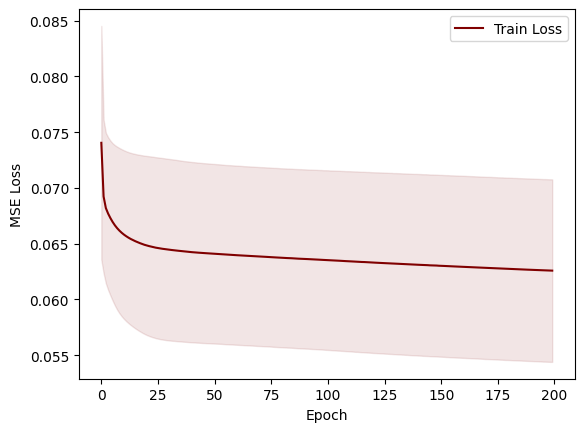

Model: GConvGRURegression
Number of parameters: 37889


100%|██████████| 200/200 [14:40:41<00:00, 264.21s/it]   

MSE: 0.0791 ± 0.0120, MAE: 0.2388 ± 0.0236, RMSE: 0.2805 ± 0.0206


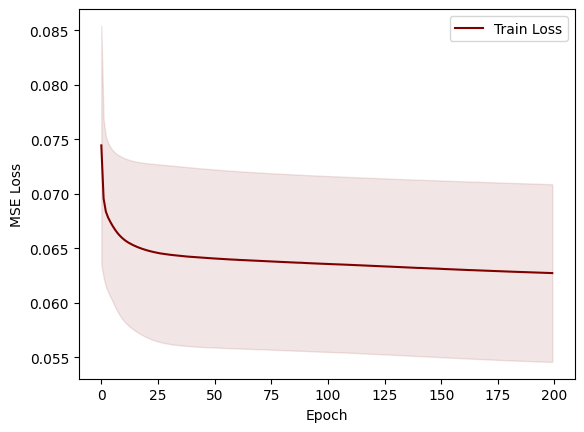

In [173]:
import torch
import torch.nn as nn
import signatory
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GConvGRURegression,GConvLSTMRegression,DCRNN
from pygsig.graph import StaticGraphTemporalSignal, split_nodes
from pygsig.signature import SignatureFeatures

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_splits = 5
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 200
num_nodes = seq_dataset[0].num_nodes
dim = seq_dataset[0].num_node_features
num_snapshots = seq_dataset[0].snapshot_count

learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False


mse_models = []
mae_models = []
rmse_models = []


for model_class in [GConvLSTMRegression,GConvGRURegression]:  # Iterate over the model classes
    print(f'Model: {model_class.__name__}')
    print(f"Number of parameters: {sum(p.numel() for p in model_class(num_channels=[dim, num_hidden, 1], K=3).parameters() if p.requires_grad)}")

    criterion = nn.MSELoss()
    
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs, num_snapshots])
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs, num_snapshots])
    mse = np.zeros([num_splits, num_runs, num_trials])
    mae = np.zeros([num_splits, num_runs, num_trials])
    rmse = np.zeros([num_splits, num_runs, num_trials])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits, test_ratio=1.0, seed=29)
        
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            
            for run, seq in enumerate(seq_dataset):
                
                for trial in range(num_trials):
                    # Create a new instance of the model for each trial
                    model = model_class(num_channels=[dim, num_hidden, 1], K=3)
                    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lasso)
                    
                    for epoch in range(num_epochs):
                        for t, snapshot in enumerate(seq):
                            # Train
                            model.train()
                            optimizer.zero_grad()
                            out = model(snapshot.x, snapshot.edge_index)
                            train_loss = criterion(out[train_mask], snapshot.y[train_mask])
                            train_loss.backward()
                            optimizer.step()

                            # Evaluate
                            model.eval()
                            with torch.no_grad():
                                eval_loss = criterion(out[eval_mask], snapshot.y[eval_mask])
                                train_losses[split, run, trial, epoch, t] = train_loss.item()
                                eval_losses[split, run, trial, epoch, t] = eval_loss.item()

                        if print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}')
                    
                    pbar.update(1)

                    # Compute the errors on the testing loss after the last epoch
                    with torch.no_grad():
                        out = model(snapshot.x, snapshot.edge_index)
                        mse[split, run, trial] = mean_squared_error(snapshot.y[test_mask], out[test_mask])
                        mae[split, run, trial] = mean_absolute_error(snapshot.y[test_mask], out[test_mask])
                        rmse[split, run, trial] = np.sqrt(mean_squared_error(snapshot.y[test_mask], out[test_mask]))

    print(f'MSE: {np.mean(mse):.4f} ± {np.std(mse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f}, RMSE: {np.mean(rmse):.4f} ± {np.std(rmse):.4f}')  
    mse_models.append(mse)
    mae_models.append(mae)
    rmse_models.append(rmse)

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0, 1, 2, -1))
    avg_eval_losses = np.mean(eval_losses, axis=(0, 1, 2, -1))
    std_train_losses = np.std(train_losses, axis=(0, 1, 2, -1))
    std_eval_losses = np.std(eval_losses, axis=(0, 1, 2, -1))
    
    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

## TS2Vec

In [4]:
import torch
filename = 'datasets/brownian/1d-3b-LF-train.pt'
seq_dataset = torch.load(filename)

X_train = torch.stack([torch.stack([snapshot.x for snapshot in seq]) for seq in seq_dataset]).view(-1,seq_dataset[0].snapshot_count,1).numpy()

In [75]:
from ts2vec.ts2vec import TS2Vec
import signatory

encoder = TS2Vec(
    input_dims=1,
    device='cpu',
    hidden_dims=64,
    output_dims=30,
    batch_size=32,
)


loss_log = encoder.fit(
    X_train,
    verbose=True,
)


Epoch #0: loss=4.87707955093794
Epoch #1: loss=2.9033135496160036
Epoch #2: loss=2.7814992909790366
Epoch #3: loss=2.6618099058828046
Epoch #4: loss=2.6035226545026227
Epoch #5: loss=2.5442097622861146


In [175]:
import torch
filename = 'encoders/TS2Vec.pt'
torch.save(encoder,filename)

In [90]:
import torch
filename = 'datasets/brownian/1d-3b-LF-test.pt'
seq_dataset = torch.load(filename)

Dataset with TS2Vec features

In [8]:
from torch_geometric.data import Data
from tqdm import tqdm

import torch
filename = 'encoders/TS2Vec.pt'
encoder = torch.load(filename)

dataset = []
for seq in tqdm(seq_dataset):
    ts = torch.stack([snapshot.x for snapshot in seq]).view(-1,seq.snapshot_count,1).numpy()
    x = torch.tensor(encoder.encode(ts, encoding_window='full_series'))
    new_graph = Data(x=x,edge_index=seq.edge_index,edge_weight=seq.edge_weight,y=seq.y)
    dataset.append(new_graph)

100%|██████████| 10/10 [06:20<00:00, 38.07s/it]


Train

In [9]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt



import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNRegression, MLPRegression
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = seq_dataset[0].num_nodes
dim = seq_dataset[0].num_node_features
out_channels = 1
num_splits = 5 # split the nodes
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 200

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

all_models = []
all_model_parameters = []
all_model_layers = []
all_models_mse = []
all_models_mae = []
all_models_rmse = []

# create models 
min_layers = 3
max_layers = 3

for num_layers in range(min_layers,max_layers):
    in_channels = dataset[0].x.shape[1]
    model = GCNRegression(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Name: {model._get_name()}')
    print(f"Number of parameters: {num_params}")
    print(f"Number of layers: {num_layers+1}")
    print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
    all_model_parameters.append(num_params)
    all_model_layers.append(num_layers+1)
    
    criterion = nn.MSELoss() # loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    mse = np.zeros([num_splits, num_runs, num_trials])
    mae = np.zeros([num_splits, num_runs, num_trials])
    rmse = np.zeros([num_splits, num_runs, num_trials])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for run, data in enumerate(dataset):
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        # train
                        model.train()
                        optimizer.zero_grad()
                        out = model(data.x, data.edge_index)
                        train_loss = criterion(out[train_mask], data.y[train_mask])
                        train_loss.backward()
                        optimizer.step()
                        # evaluate
                        model.eval()
                        with torch.no_grad():
                            eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                            train_losses[split, run, trial, epoch] = train_loss.item()
                            eval_losses[split, run, trial, epoch] = eval_loss.item()
                        if epoch % 10 == 0 and print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                    pbar.update(1)
                    # compute the errors on the testing loss after the last epoch
                    with torch.no_grad():
                        out = model(data.x, data.edge_index)
                        mse[split, run, trial] = mean_squared_error(data.y[test_mask], out[test_mask])
                        mae[split, run, trial] = mean_absolute_error(data.y[test_mask], out[test_mask])
                        rmse[split, run, trial] = np.sqrt(mean_squared_error(data.y[test_mask], out[test_mask]))

    print(f'RMSE: {np.mean(rmse):.4f} ± {np.std(rmse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f}')  
    all_models_mse.append(mse)
    all_models_mae.append(mae)
    all_models_rmse.append(rmse)

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1,2))
    avg_eval_losses = np.mean(eval_losses, axis=(0,1,2))
    std_train_losses = np.std(train_losses, axis=(0,1,2))
    std_eval_losses = np.std(eval_losses, axis=(0,1,2))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

Name: MLPRegression
Number of parameters: 2049
Number of layers: 2
Splits: 5, Trials: 4, Runs: 10, Epochs: 200


100%|██████████| 200/200 [00:11<00:00, 17.03it/s]


MSE: 0.0119 ± 0.0034, MAE: 0.0873 ± 0.0147, RMSE: 0.1080 ± 0.0153


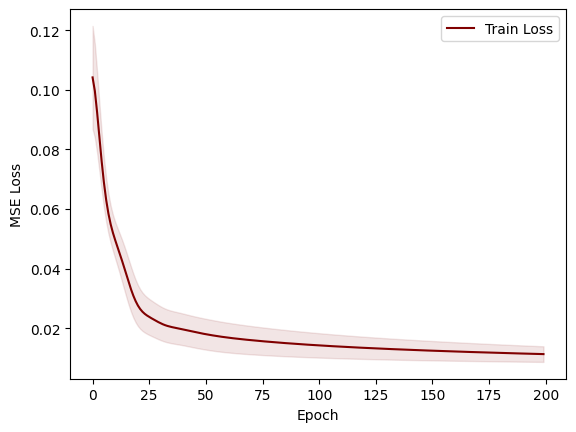

Name: MLPRegression
Number of parameters: 6209
Number of layers: 3
Splits: 5, Trials: 4, Runs: 10, Epochs: 200


100%|██████████| 200/200 [00:16<00:00, 12.03it/s]


MSE: 0.0076 ± 0.0021, MAE: 0.0648 ± 0.0115, RMSE: 0.0862 ± 0.0119


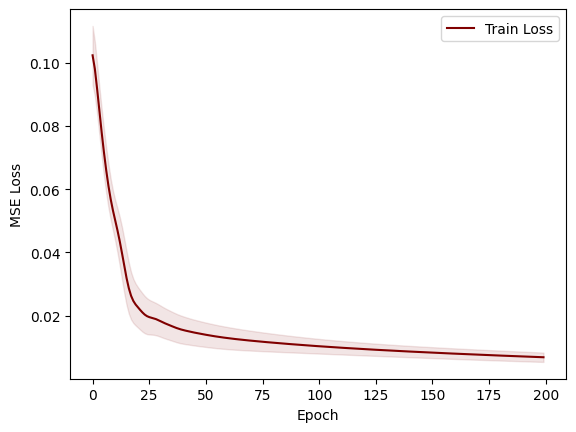

Name: MLPRegression
Number of parameters: 10369
Number of layers: 4
Splits: 5, Trials: 4, Runs: 10, Epochs: 200


100%|██████████| 200/200 [00:22<00:00,  8.93it/s]

MSE: 0.0047 ± 0.0013, MAE: 0.0474 ± 0.0090, RMSE: 0.0680 ± 0.0098


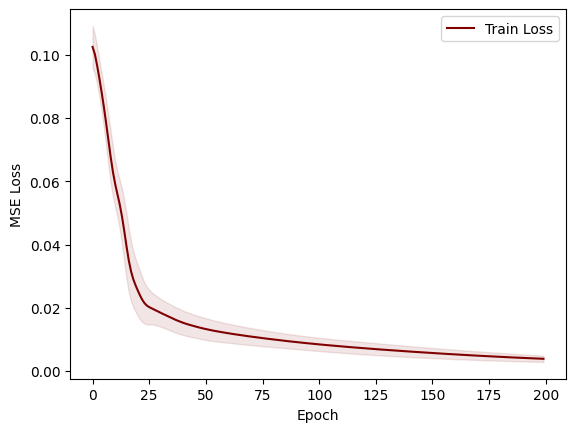

Name: MLPRegression
Number of parameters: 14529
Number of layers: 5
Splits: 5, Trials: 4, Runs: 10, Epochs: 200


100%|██████████| 200/200 [00:24<00:00,  8.07it/s]

MSE: 0.0034 ± 0.0011, MAE: 0.0372 ± 0.0082, RMSE: 0.0576 ± 0.0090


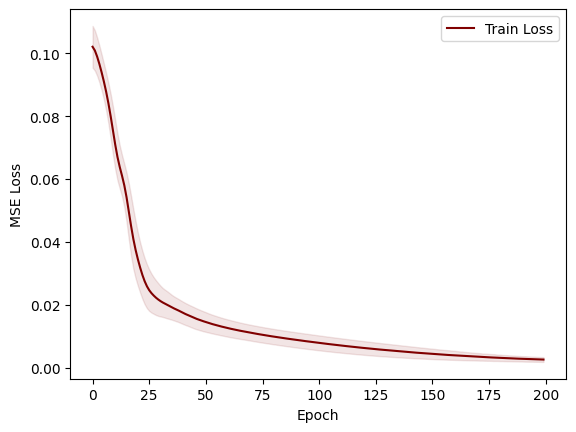

In [96]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt



import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNRegression, MLPRegression
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = seq_dataset[0].num_nodes
dim = seq_dataset[0].num_node_features
out_channels = 1
num_splits = 5 # split the nodes
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 200

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

all_models = []
all_model_parameters = []
all_model_layers = []
all_models_mse = []
all_models_mae = []
all_models_rmse = []

# create models 
min_layers = 1
max_layers = 5

for num_layers in range(min_layers,max_layers):
    in_channels = dataset[0].x.shape[1]
    model = MLPRegression(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Name: {model._get_name()}')
    print(f"Number of parameters: {num_params}")
    print(f"Number of layers: {num_layers+1}")
    print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
    all_model_parameters.append(num_params)
    all_model_layers.append(num_layers+1)
    
    criterion = nn.MSELoss() # loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    mse = np.zeros([num_splits, num_runs, num_trials])
    mae = np.zeros([num_splits, num_runs, num_trials])
    rmse = np.zeros([num_splits, num_runs, num_trials])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for run, data in enumerate(dataset):
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        # train
                        model.train()
                        optimizer.zero_grad()
                        out = model(data.x, data.edge_index)
                        train_loss = criterion(out[train_mask], data.y[train_mask])
                        train_loss.backward()
                        optimizer.step()
                        # evaluate
                        model.eval()
                        with torch.no_grad():
                            eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                            train_losses[split, run, trial, epoch] = train_loss.item()
                            eval_losses[split, run, trial, epoch] = eval_loss.item()
                        if epoch % 10 == 0 and print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                    pbar.update(1)
                    # compute the errors on the testing loss after the last epoch
                    with torch.no_grad():
                        out = model(data.x, data.edge_index)
                        mse[split, run, trial] = mean_squared_error(data.y[test_mask], out[test_mask])
                        mae[split, run, trial] = mean_absolute_error(data.y[test_mask], out[test_mask])
                        rmse[split, run, trial] = np.sqrt(mean_squared_error(data.y[test_mask], out[test_mask]))

    print(f'MSE: {np.mean(mse):.4f} ± {np.std(mse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f}, RMSE: {np.mean(rmse):.4f} ± {np.std(rmse):.4f}')  
    all_models_mse.append(mse)
    all_models_mae.append(mae)
    all_models_rmse.append(rmse)

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1,2))
    avg_eval_losses = np.mean(eval_losses, axis=(0,1,2))
    std_train_losses = np.std(train_losses, axis=(0,1,2))
    std_eval_losses = np.std(eval_losses, axis=(0,1,2))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()